In [12]:
#pip install numpy tensorflow matplotlib

In [13]:
#Initialize Q-table for a simple grid world environment
import numpy as np

# Define the grid size and actions
grid_size = 5
n_actions = 4  # Actions: up, down, left, right

# Initialize the Q-table with zeros
Q_table = np.zeros((grid_size * grid_size, n_actions))

In [14]:
#Define hyperprameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Exploration rate for epsilon-greedy policy

In [15]:
#Define reward structure
# Reward matrix for the grid environment
rewards = np.full((grid_size * grid_size,), -1)  # -1 for every state
rewards[24] = 10  # Goal state
rewards[12] = -10  # Pitfall state

In [25]:
# Define the number of actions (up, down, left, right)
n_actions = 4

def epsilon_greedy_action(Q_table, state, epsilon):
    # Epsilon-greedy strategy: with probability epsilon, take a random action (exploration)
    # otherwise take the action with the highest Q-value for the given state (exploitation)
    if np.random.rand() < epsilon:  # Exploration
        return np.random.randint(0, Q_table.shape[1])  # Random action
    else:  # Exploitation
        return np.argmax(Q_table[state])  # Action with the highest Q-value


alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate for epsilon-greedy policy

# Initialize the Q-table
Q_table = np.zeros((n_states, n_actions))

# Training loop
for episode in range(1000):
    state = np.random.randint(0, n_states)  # Start at random state
    done = False
    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, n_states)  # Random next state
        reward = rewards[next_state]

        # Q-learning update rule
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])

        state = next_state
        if next_state == 24 or next_state == 12:  # End episode if goal or pitfall is reached
            done = True

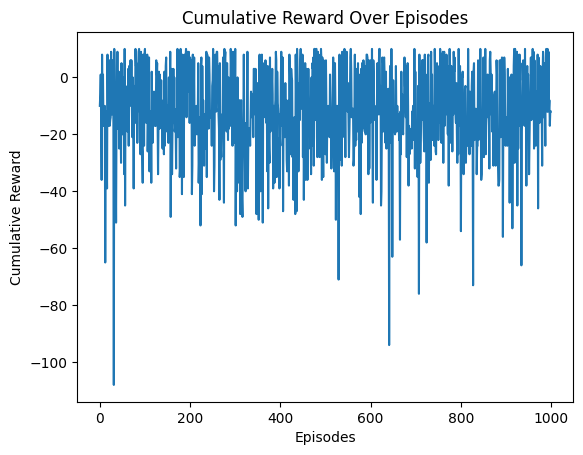

In [26]:
import matplotlib.pyplot as plt

# Calculate and store cumulative rewards
cumulative_rewards = []
for episode in range(1000):
    total_reward = 0
    state = np.random.randint(0, n_states)
    done = False
    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, n_states)
        reward = rewards[next_state]
        total_reward += reward
        state = next_state
        if next_state == 24 or next_state == 12:
            done = True
    cumulative_rewards.append(total_reward)

# Plot the cumulative rewards over episodes
plt.plot(cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Over Episodes')
plt.show()

In [37]:
# Redefine epsilon_greedy_action to log explorations & exploitations
actions = []
def epsilon_greedy_action(Q_table, state, epsilon):
    # Epsilon-greedy strategy: with probability epsilon, take a random action (exploration)
    # otherwise take the action with the highest Q-value for the given state (exploitation)
    if np.random.rand() < epsilon:  # Exploration
        actions.append('explore')
        return np.random.randint(0, Q_table.shape[1])  # Random action
    else:  # Exploitation
        actions.append('exploit')
        return np.argmax(Q_table[state])  # Action with the highest Q-value

# Calculate and store cumulative rewards and actions
cumulative_rewards = []
for episode in range(1000):
    total_reward = 0
    state = np.random.randint(0, n_states)
    done = False
    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, n_states)
        reward = rewards[next_state]
        total_reward += reward
        state = next_state
        if next_state == 24 or next_state == 12:
            done = True
    cumulative_rewards.append(total_reward)

# Calculate success rate
success_count = sum(1 for reward in cumulative_rewards if reward >= 10)
success_rate = success_count / len(cumulative_rewards)

# Exploration vs. exploitation ratio
#print(actions)
exploration_count = sum(1 for action in actions if action == 'explore')
exploitation_count = sum(1 for action in actions if action == 'exploit')
exploration_exploitation_ratio = exploration_count / (exploration_count + exploitation_count)
rewards_q_learning = cumulative_rewards
print(f"Success Rate: {success_rate * 100}%")
print(f"Exploration vs. Exploitation Ratio: {exploration_exploitation_ratio}")

Success Rate: 4.1000000000000005%
Exploration vs. Exploitation Ratio: 0.102012275658457


#Implement policy gradient

In [18]:
#Build a policy network
import tensorflow as tf

# Define the policy network
n_states = grid_size * grid_size  # Number of states in the grid
n_actions = 4  # Up, down, left, right

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(n_states,)),
    tf.keras.layers.Dense(n_actions, activation='softmax')  # Output action probabilities
])

# Optimizer for policy network updates
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [19]:
#Select action
def get_action(state):
    state_input = tf.one_hot(state, n_states)  # One-hot encoding for state
    action_probs = model(state_input[np.newaxis, :])
    return np.random.choice(n_actions, p=action_probs.numpy()[0])


In [20]:
#Simulate the environment
# Simulation loop
states = []
actions = []
episode_rewards = []  

for episode in range(1000):
    state = np.random.randint(0, n_states)  # Start in a random state
    done = False
    while not done:
        action = get_action(state)  # Use the provided function
        next_state = np.random.randint(0, n_states)  # Simulated next state
        reward = rewards[next_state]  

        # Store the state-action-reward trajectory
        states.append(state)
        actions.append(action)
        episode_rewards.append(reward)  

        state = next_state
        if next_state in {24, 12}:  
            done = True
            

In [21]:
def compute_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cumulative_rewards[t] = running_add
    return cumulative_rewards

In [35]:
#update policy
def update_policy(states, actions, rewards):
    cumulative_rewards = compute_cumulative_rewards(rewards)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)  # Convert states to one-hot encoding
        action_probs = model(state_inputs)
        action_masks = tf.one_hot(actions, n_actions)  # Mask for selected actions
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs), axis=1)

        # Policy loss is the negative log-probability of the action times the cumulative reward
        loss = -tf.reduce_mean(log_probs * cumulative_rewards)

    # Apply gradients to update the policy network
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

rewards_policy_gradients = compute_cumulative_rewards(rewards)    

Comparison and analysis


Convergence speed: how quickly does each algorithm learn an optimal policy?

Reward maximization: which algorithm achieves higher cumulative rewards?

Exploration vs. exploitation: how do Q-learning and policy gradients handle exploration of the environment?

Suitability: which algorithm is better suited for this environment, and why?

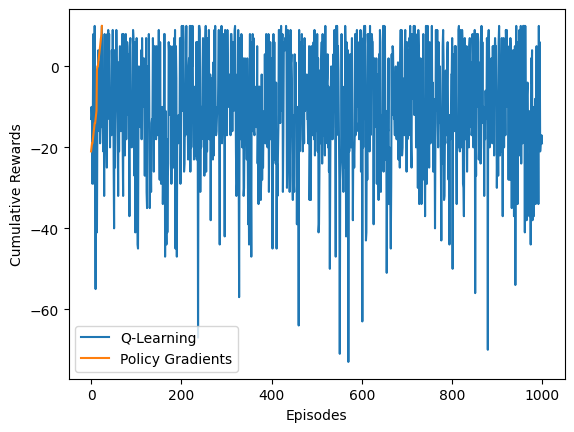

In [36]:
import matplotlib.pyplot as plt

# Example code to visualize rewards over episodes
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_policy_gradients, label='Policy Gradients')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.show()